In [ ]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np

from jax import vmap, lax
from flax import linen as nn
from numba import jit
import torch.utils.data as data
from tqdm import tqdm

#based on:
#https://glouppe.github.io/ssi2023/?p=lecture-aissai.md#7

In [ ]:
@jit
def simulate(v, alpha, dt=0.001):
    G = 9.18
    v_x = v * np.cos(alpha)  # x velocity m/s
    v_y = v * np.sin(alpha)  # y velocity m/s
    y = 1.1 + 0.1 * np.random.normal()
    x = 0.0
    while y > 0: # simulate until ball hits floor
        v_y += dt * -G  # acceleration due to gravity
        x += dt * v_x
        y += dt * v_y
    return x + 0.1 * np.random.normal()

def simulate_n(v, alpha, n):
    out = [simulate(v, alpha) for _ in range(n)]
    return np.array(out)

def simulate_many(velocities, angles):
  # can just vectorize instead
  out = [simulate(v, alpha) for v, alpha in zip(velocities, angles)]
  return np.array(out)

test_length = int(10e5)
alpha, v = 10.0, 10.0
alphas, vs = np.full(test_length, alpha), np.full(test_length, v)


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = str(0)

class Classifier(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons

    def setup(self):
        # Create the modules we need to build the network
        # nn.Dense is a linear layer
        self.linear1 = nn.Dense(features=self.num_hidden)
        self.linear2 = nn.Dense(features=self.num_hidden)
        self.linear3 = nn.Dense(features=self.num_outputs)

    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = nn.selu(x)
        x = self.linear2(x)
        x = nn.selu(x)
        x = self.linear3(x)
        return x

model = Classifier(100, 1)
rng = jax.random.PRNGKey(0)
rng, inp_rng, init_rng = jax.random.split(rng, 3)
input_size, batch_size = 3, 1024
inp = jax.random.normal(inp_rng, (batch_size, input_size))
# Initialize the model
params = model.init(init_rng, inp)

model.apply(params, inp).shape

(1024, 1)

In [ ]:
class BallDataset(data.Dataset):
    def __init__(self, size=int(10e5), velocity_range=(1.0, 10.0), angle_range=(-2.0, 2.0)):
        super().__init__()
        self.size = size
        self.velocity_range = velocity_range
        self.angle_range = angle_range
        self.generate_data()

    def generate_data(self):
        # divide size by two so when we concat we get sample of shape (size,)

        size = self.size // 2
        velocities = np.random.uniform(*self.velocity_range, size=size)
        angles = np.random.uniform(*self.angle_range, size=size)

        positions = simulate_many(velocities, angles)
        #for the joint distribution we just concat with the model parameters
        joint_labels = np.ones(size)
        joint = np.stack([velocities, angles, positions], axis=1)

        #for the product of marginals we shuffle the model parameters
        marginal_labels = np.zeros(size)
        indices = np.random.permutation(np.arange(0, size))
        product_of_marginals = np.stack([
            velocities[indices],
            angles[indices],
            positions,
        ],
        axis=1)

        self.data = np.vstack([joint, product_of_marginals])
        self.labels = np.hstack([joint_labels, marginal_labels])


    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        return sample, label

def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


dataset = BallDataset()
data_loader = data.DataLoader(dataset, batch_size=1024, shuffle=True, collate_fn=numpy_collate)

In [ ]:
import optax
optimizer = optax.sgd(learning_rate=0.1)
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

def calculate_loss_acc(state, params, batch):
    data_input, labels = batch
    # Obtain the logits and predictions of the model for the input data
    logits = state.apply_fn(params, data_input).squeeze(axis=-1)
    pred_labels = (logits > 0).astype(jnp.float32)
    # Calculate the loss and accuracy
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = (pred_labels == labels).mean()
    return loss, acc

batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)

(Array(1.4164081, dtype=float32), Array(0.5253906, dtype=float32))

In [ ]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss_acc,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=True  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    (loss, acc), grads = grad_fn(state, state.params, batch)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss, acc


@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
    # Determine the accuracy
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

def train_model(state, data_loader, num_epochs=10):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for batch in data_loader:
            state, loss, acc = train_step(state, batch)
            # We could use the loss and accuracy for logging here, e.g. in TensorBoard
            # For simplicity, we skip this part here
    return state

In [ ]:
trained_model_state = train_model(model_state, data_loader, num_epochs=15)

100%|██████████| 15/15 [02:00<00:00,  8.04s/it]


In [ ]:
test_dataset = BallDataset(size=5000)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset,
                                   batch_size=128,
                                   shuffle=False,
                                   drop_last=False,
                                   collate_fn=numpy_collate)
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])
    # Weighted average since some batches might be smaller
    acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

# trained_model
eval_model(trained_model_state, test_data_loader)

Accuracy of the model: 91.92%


In [ ]:
def create_meshgrid(dataset, size):
  velocities = np.linspace(*dataset.velocity_range, size)
  angles = np.linspace(*dataset.angle_range, size)
  velocities, angles = np.meshgrid(velocities, angles)
  return velocities, angles

def evaluation_sample(position, size, dataset):
  positions = np.full(int(size**2), position)
  velocities, angles = create_meshgrid(dataset, size)
  data = np.stack([velocities.flatten(), angles.flatten(), positions], axis=1)
  return data


2.0297374575508114


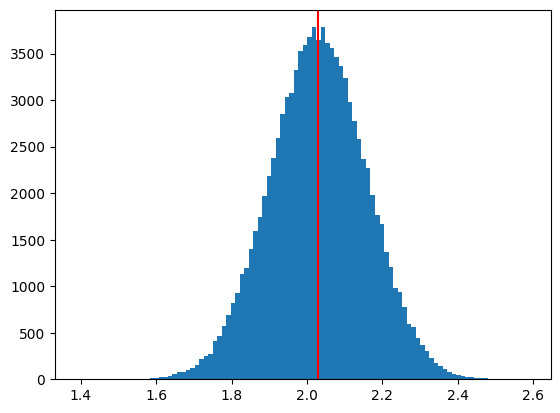

In [ ]:
eval_grid = evaluation_sample(2.1, 1000, dataset)

logits = trained_model_state.apply_fn(trained_model_state.params, eval_grid).squeeze(axis=-1)
odds = jax.nn.sigmoid(logits) / (1 - jax.nn.sigmoid(logits))


np.argmax(logits)
inferred_v, inferred_angle, x = eval_grid[np.argmax(logits)]

positions = simulate_n(inferred_v, inferred_angle, 100000)

mean_x = np.mean(positions)
print(mean_x)
plt.hist(positions, bins=100)
plt.axvline(mean_x, c='red')



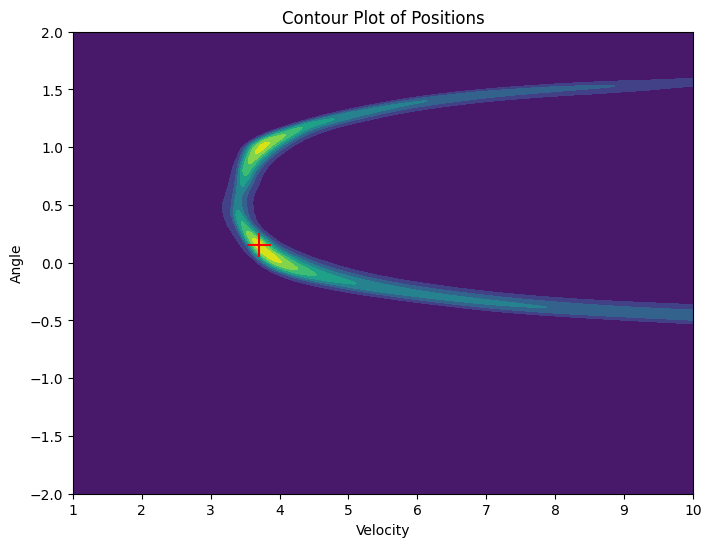

In [ ]:
# Create meshgrid for plotting
velocities, angles = create_meshgrid(dataset, 1000)

# Create the contour plot
plt.figure(figsize=(8, 6))
cp = plt.contourf(velocities, angles, odds.reshape(1000, 1000), cmap='viridis')
# plt.imshow(odds.reshape(100, 100), cmap='viridis')
plt.title('Contour Plot of Positions')
plt.xlabel('Velocity')
plt.ylabel('Angle')
plt.scatter(inferred_v, inferred_angle, s=300, color='red', marker='+')
plt.show()


In [ ]:
true_v, true_alpha

(4.5, 1.0)